In [1]:
import numpy as np
import scipy as sy
import pandas as pd

import time
import sys
import os
import ast
import json
import copy 
import itertools

from itertools import islice
from tqdm import *
from math import ceil
from collections import defaultdict
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.sparse import csr_matrix, dok_matrix
from ipynb.fs.full.Random_Sample_Mapper import *

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Read In Data

In [2]:
notebook_path = os.path.abspath("BPR_OPT_Binary_Model.ipynb")
users_items_file_path = os.path.join(os.path.dirname(notebook_path), "data/australian_users_items.json")
items_file_path = os.path.join(os.path.dirname(notebook_path), "data/items_meta_data.json")
users_meta_data_file_path = os.path.join(os.path.dirname(notebook_path), "data/users_meta_data.json")

In [3]:
users_items = []
with open(users_items_file_path, 'r') as data:
    for line in data:
        users_items.append(ast.literal_eval(line))

In [4]:
with open(items_file_path, 'r') as data:
    games_dict = json.load(data)

In [ ]:
with open(users_meta_data_file_path, 'r') as file:
    users_meta_data = json.load(file)

# Process Data into Training and Testing Sets

Using default dict for efficient data retrieval for users-items playtime relationship

In [5]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
playtimesPerItem = defaultdict(dict)
playtimesPerUser = defaultdict(dict)
itemNames = defaultdict(str)

In [6]:
for game in games_dict:
    if 'owners' in games_dict[game]:
        usersPerItem[game] = set(games_dict[game]['owners'].keys())

In [7]:
for user in users_items:
    u_id = user['user_id']
    items = [item['item_id'] for item in user['items']]
    itemsPerUser[u_id] = items
    playtimesPerUser[user['user_id']] = dict((item['item_id'], item['playtime_forever']) for item in user['items'])
    for item in user['items']:
        itemNames[item['item_id']] = item['item_name']
        playtimesPerItem[item['item_id']][user['user_id']] = item['playtime_forever']

## Scheduled Sampling with Map-Reduce Algorithm

In [8]:
nUsers = len(itemsPerUser)
nItems = len(usersPerItem)
users = list(itemsPerUser.keys())
items = list(usersPerItem.keys())

In [9]:
user_item_counts = dict((k, len(v)) for k, v in itemsPerUser.items())

In [10]:
datafile = 'data/sample_in.tsv'
mapout1 = 'data/sample_map1.tsv'
mapout2 = 'data/sample_map2.tsv'
outfile = 'data/sample_out.tsv'

f = open(datafile,'w')
for u, its in itemsPerUser.items():
    for i in its:
        print(default_formatter(u,i), file=f)
f.close()

In [12]:
# run two stages of mapreduce
mapper = Mapper(user_item_counts)
mapreduce(datafile, mapout1, mapper=mapper, reducer=reducer)
mapreduce(datafile, mapout2, mapper=indicator_mapper)  # map the data again
mapreduce([mapout1, mapout2], outfile, reducer=indicator_reducer)

In [13]:
def trim(u, i, j):
    return u[1:len(u)-1], i[2:len(i)-2], j[1:len(j)-2]

In [14]:
def create_data(filepath):
    f = open(filepath)
    samples = [map(str, line.strip().split()) for line in f]
    return [trim(u, i, j) for u, i, j in samples]

In [15]:
def create_random_batches(data, batch_size=1024):
    batches = []
    random.shuffle(data)
    num_batches = int(len(data)/batch_size)
    for i in range(num_batches):
        mini_batch = data[i*batch_size:(i+1)*batch_size]
        batches.append(mini_batch)
    return batches

In [16]:
data = create_data(outfile)

In [17]:
sample_data = train_test_split(data, train_size=0.05)[0]

/home/arnold/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
sampleUsersPerItem = defaultdict(set)
sampleItemsPerUser = defaultdict(set)

In [19]:
for u, i, j in sample_data:
    sampleUsersPerItem[i].add(u)
    sampleItemsPerUser[u].add(i)

In [20]:
train_data = sample_data
sampleItems = list(sampleUsersPerItem.keys())
sampleUsers = list(sampleItemsPerUser.keys())

In [21]:
test_data = []
for u in sampleItemsPerUser:
    for i in sampleItemsPerUser[u]:
        j = random.choice(sampleItems)
        test_data.append((u, i, j))

# Utility Functions

In [22]:
def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

In [96]:
def graph(data, title):
    plt.plot([x for x in range(len(data))], data, linewidth=2.0)
    plt.title(title)
    plt.show()

In [23]:
def binary_label(u, i, j):
    c = Counter(itemsPerUser[u])
    if c[i] >= c[j]:
        return 1
    else:
        return 0

In [101]:
def generate_outputs(sample, binary):
    predictions = []
    labels = []
    for u, i, j in sample:
        predict = sigmoid(prediction(u, i, j))
        label = binary(u, i, j)
        predictions.append(predict)
        labels.append(label)
            
    return np.rint(predictions), labels

In [25]:
def accuracy(predictions, labels):
    differences = [1 if x == y else 0 for x, y in zip(predictions, labels)]
    return sum(differences) / len(differences)

In [26]:
train_labels = [binary_label(u, i, j) for u, i, j in train_data]

## Sigmoid Function

\begin{equation*}
\sigma(x) = \frac{1}{1 + e^{-x}}
\end{equation*}

In [27]:
def sigmoid(x):
    #Numerically stable sigmoid function.
    #Taken from: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        # if x is less than zero then z will be small, denom can't be
        # zero because it's 1+z.
        z = np.exp(x)
        return z / (1 + z)

# Simple (Bias Only) Latent Factor Model with Binary Classification

In [28]:
loss_history = []
train_accuracy_history = []

In [29]:
itemBiases = defaultdict(float)

In [30]:
def unpack(theta):
    global itemBiases
    itemBiases = dict(zip(items, theta))

## Prediction Function

\begin{equation*}
f(i, j) = \beta_i - \beta_j
\end{equation*}

\begin{equation*}
p(i >_u j) = \sigma(f(i, j))
\end{equation*}

In [31]:
def prediction(u, item_i, item_j):
    return itemBiases[item_i] - itemBiases[item_j]

\begin{equation*}
\text{Cost Function (arg min)}:= \sum_{u,i,j} -\ln(\sigma(\beta_i - \beta_j)) + \lambda \sum_i \beta_i^2 = \sum_{u,i,j} -ln\left( \frac{1}{1 + e^{\beta_j - \beta_i}} \right) + \lambda \sum_i \beta_i^2
\end{equation*}

## Cost Function

In [86]:
def cost(theta, lamb, train_data, train_labels):
    unpack(theta)
    cost = 0.0
    predictions = []
    for u, i, j in train_data:
        x = prediction(u, i, j)
        predictions.append(sigmoid(x))
        cost += np.log(sigmoid(x))

    for i in itemBiases:
        cost -= lamb*itemBiases[i]**2

    train_accuracy = accuracy(np.rint(predictions), train_labels)
    loss_history.append(-cost)
    train_accuracy_history.append(train_accuracy)
    print('iteration {0} Cost: {1}'.format(len(loss_history), -cost))
    print('iteration {0} Training Accuracy: {1}'.format(len(train_accuracy_history), train_accuracy))
    print('-------------------------------------------------------------------')

    return -cost

\begin{equation*}
\frac{\partial }{\partial x} ln\sigma(x) = \frac{1}{1 + e^x} = \sigma(-x)
\end{equation*}

## Partial Derivatives

\begin{equation*}
\frac{\partial f}{\partial \beta_i} = -\frac{e^{\beta_j - \beta_i}}{1 + e^{\beta_j - \beta_i}} + 2 \lambda \beta_j = -\frac{1}{1 + e^{\beta_i - \beta_j}} + 2 \lambda \beta_j
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial \beta_j} = \frac{e^{\beta_j - \beta_i}}{1 + e^{\beta_j - \beta_i}} + 2 \lambda \beta_j = \frac{1}{1 + e^{\beta_i - \beta_j}} + 2 \lambda \beta_j
\end{equation*}

### [Important]: switch the sign of all partial derivatives to compute your gradient ascent

In [87]:
def derivative(theta, lamb, train_data, train_labels):
    unpack(theta)
    dItemBiases = defaultdict(float)
    for u, i, j in train_data:
        x = prediction(u, i, j)
        dbase = 1 / (1 + np.exp(x)) # negative gradient descent for maximizing
        dItemBiases[i] += -dbase
        dItemBiases[j] += dbase
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dItemBiases[i] for i in items]
    return np.array(dtheta)

In [35]:
d

{'grad': array([ 6.44442241e-05,  1.95088158e-04, -1.29187156e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'funcalls': 532,
 'nit': 512,
 'warnflag': 0}

In [36]:
unpack(res)

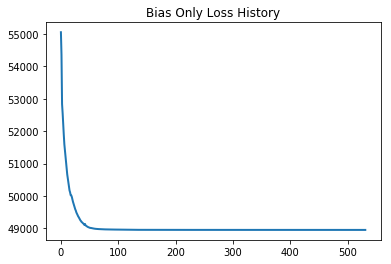

In [37]:
plt.plot([x for x in range(len(loss_history))], loss_history, linewidth=2.0)
plt.title('Bias Only Loss History')
plt.show()

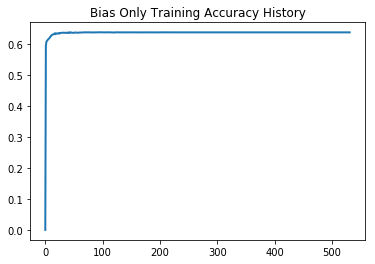

In [38]:
plt.plot([x for x in range(len(train_accuracy_history))], train_accuracy_history, linewidth=2.0)
plt.title('Bias Only Training Accuracy History')
plt.show()

In [39]:
predictions, labels = generate_outputs(test_data, binary_label)

In [40]:
accuracy(predictions, labels)

0.5805602769908719

In [41]:
np.save('./data/bias_only_itemBiases', itemBiases)
np.save('./data/bias_only_loss', loss_history)
np.save('./data/bias_only_train_accuracy', train_accuracy_history)

# Complete Latent Factor Model with Binary Classification

This code extends the example above to implement a complete latent factor model (i.e., including low-dimensional user and item terms).

In [42]:
loss_history = []
train_accuracy_history = []

In [43]:
itemBiases = defaultdict(float)

For each user and item we now have a low dimensional descriptor (representing that user's preferences, and that item's properties), of dimension K.

In [44]:
userGamma = {}
itemGamma = {}

In [45]:
K = 10

In [46]:
for u in itemsPerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]

In [47]:
for i in usersPerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

We'll use another library in this example to perform gradient descent. This library requires that we pass it a "flat" parameter vector (theta) containing all of our parameters. This utility function just converts between a flat feature vector, and our model parameters, i.e., it "unpacks" theta into our offset and bias parameters.

In [48]:
def unpack(theta):
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    itemBiases = dict(zip(items, theta[0:index + nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index + K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index + K]
        index += K

## Prediction Function

\begin{equation*}
f(u, i, j) = \gamma_u \gamma_i + \beta_i - (\gamma_u \gamma_j + \beta_j)
\end{equation*}

\begin{equation*}
p(i >_u j) = \sigma(f(u, i, j))
\end{equation*}

In [49]:
def prediction(user, item_i, item_j):
    return inner(userGamma[user], itemGamma[item_i]) + itemBiases[item_i] - (inner(userGamma[user], itemGamma[item_j]) + itemBiases[item_j]) 

## Cost Function

\begin{equation*}
\text{Cost Function (arg min)}:= \sum_{u,i,j} -\ln(\sigma(\gamma_u \gamma_i + \beta_i - (\gamma_u \gamma_j + \beta_j))) + \lambda [\sum_i \beta_i^2 + \sum_i ||\gamma_i||_2^2 + \sum_u ||\gamma_u||_2^2 ]
\end{equation*}

\begin{equation*}
\sum_{u,i,j} \ln(\sigma(\gamma_u \gamma_i + \beta_i - (\gamma_u \gamma_j + \beta_j))) = \sum_{u,i,j} ln\left( \frac{1}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} \right)
\end{equation*}

In [111]:
def cost(theta, lamb, train_data, train_labels):
    unpack(theta)
    cost = 0.0
    predictions = []
    for u, i, j in train_data:
        x = prediction(u, i, j)
        predictions.append(sigmoid(x))
        cost += np.log(sigmoid(x))
        
    for u in users:
        for k in range(K):
            cost -= lamb*userGamma[u][k]**2
    for i in items:
        cost -= lamb*itemBiases[i]**2
        for k in range(K):
            cost -= lamb*itemGamma[i][k]**2
        
    train_accuracy = accuracy(np.rint(predictions), train_labels)
    loss_history.append(-cost)
    train_accuracy_history.append(train_accuracy)
    print('iteration {0} Cost: {1}'.format(len(loss_history), -cost))
    print('iteration {0} Training Accuracy: {1}'.format(len(train_accuracy_history), train_accuracy))
    print('-------------------------------------------------------------------')
        
    return -cost

## Partial Derivatives

\begin{equation*}
\frac{\partial f}{\partial \gamma_{u,k}} = \frac{(\gamma_{j,k} - \gamma_{i,k}) \cdot e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} + 2 \lambda \gamma_{i,k} 
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial \gamma_{i,k}} = -\frac{\gamma_{u,k} \cdot e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} + 2 \lambda \gamma_{i,k}
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial \gamma_{j,k}} = \frac{\gamma_{u,k} \cdot e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} + 2 \lambda \gamma_{j,k}
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial \beta_i} = -\frac{e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} + 2 \lambda \beta_i
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial \beta_j} = \frac{e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} + 2 \lambda \beta_j
\end{equation*}

In [112]:
def derivative(theta, lamb, train_data, train_labels):
    unpack(theta)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in users:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in items:
        dItemGamma[i] = [0.0 for k in range(K)]
    for u, i, j in train_data:
        x = prediction(u, i ,j)
        dbase = 1 / (1 + np.exp(x))
        dItemBiases[i] += -dbase
        dItemBiases[j] += dbase
        for k in range(K):
            dUserGamma[u][k] += (itemGamma[j][k] - itemGamma[i][k]) * dbase
            dItemGamma_k = userGamma[u][k] * dbase
            dItemGamma[i][k] += -dItemGamma_k
            dItemGamma[j][k] += dItemGamma_k
    for u in userGamma:
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return np.array(dtheta)

In [52]:
complete_res, complete_f, complete_d = sy.optimize.fmin_l_bfgs_b(cost, 
                                [0.0]*nItems + # Initialize beta
                                [random.random() * 0.1 - 0.05 for k in range(K*(nUsers + nItems))], # Gamma
                                derivative, args=[0.001, train_data, train_labels])

iteration 1 Cost: 55054.96888664958
iteration 1 Training Accuracy: 0.49867170286433743
-------------------------------------------------------------------
iteration 2 Cost: 54358.67536017296
iteration 2 Training Accuracy: 0.5976078061063896
-------------------------------------------------------------------
iteration 3 Cost: 52828.768734197525
iteration 3 Training Accuracy: 0.6083978596159899
-------------------------------------------------------------------
iteration 4 Cost: 52543.26084192437
iteration 4 Training Accuracy: 0.6097576329870947
-------------------------------------------------------------------
iteration 5 Cost: 52163.16773932139
iteration 5 Training Accuracy: 0.613257790368272
-------------------------------------------------------------------
iteration 6 Cost: 51816.73095067258
iteration 6 Training Accuracy: 0.6161284230406043
-------------------------------------------------------------------
iteration 7 Cost: 51462.28312730872
iteration 7 Training Accuracy: 0.619490

iteration 55 Cost: 323.5038874912919
iteration 55 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 56 Cost: 358.97550937799656
iteration 56 Training Accuracy: 0.9999244570349386
-------------------------------------------------------------------
iteration 57 Cost: 318.2021565665649
iteration 57 Training Accuracy: 0.9999874095058231
-------------------------------------------------------------------
iteration 58 Cost: 330.5050570121979
iteration 58 Training Accuracy: 0.9999370475291155
-------------------------------------------------------------------
iteration 59 Cost: 314.50255078378973
iteration 59 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 60 Cost: 311.4098750214686
iteration 60 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 61 Cost: 308.49613075202717
iteration 61 Training Accuracy: 0.9999874095058231
------------------

iteration 111 Cost: 201.50732668531757
iteration 111 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 112 Cost: 302.4837856693639
iteration 112 Training Accuracy: 0.9997985520931697
-------------------------------------------------------------------
iteration 113 Cost: 199.9701576037876
iteration 113 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 114 Cost: 212.26149945971977
iteration 114 Training Accuracy: 0.9999496380232924
-------------------------------------------------------------------
iteration 115 Cost: 197.6914404371318
iteration 115 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 116 Cost: 390.1921004943273
iteration 116 Training Accuracy: 0.9996474661630469
-------------------------------------------------------------------
iteration 117 Cost: 196.5224253390693
iteration 117 Training Accuracy: 1.0
--------------------

iteration 167 Cost: 192.13277412744273
iteration 167 Training Accuracy: 0.9998992760465848
-------------------------------------------------------------------
iteration 168 Cost: 155.41753943925497
iteration 168 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 169 Cost: 161.87006567971667
iteration 169 Training Accuracy: 0.9999622285174693
-------------------------------------------------------------------
iteration 170 Cost: 154.26355014499137
iteration 170 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 171 Cost: 153.29385884188198
iteration 171 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 172 Cost: 152.61345916887433
iteration 172 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 173 Cost: 152.26308790668588
iteration 173 Training Accuracy: 1.0
------------------------------

iteration 224 Cost: 140.3293086441329
iteration 224 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 225 Cost: 140.2597853527245
iteration 225 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 226 Cost: 140.2160820279839
iteration 226 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 227 Cost: 140.1168392651779
iteration 227 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 228 Cost: 140.66235984702962
iteration 228 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 229 Cost: 140.01395944347772
iteration 229 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 230 Cost: 139.81768984445014
iteration 230 Training Accuracy: 1.0
----------------------------------------------------------------

iteration 281 Cost: 135.7947509769073
iteration 281 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 282 Cost: 135.94877884518277
iteration 282 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 283 Cost: 135.71309037083373
iteration 283 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 284 Cost: 135.81469272299975
iteration 284 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 285 Cost: 135.62449332241044
iteration 285 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 286 Cost: 135.5239822124571
iteration 286 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 287 Cost: 135.5008697551744
iteration 287 Training Accuracy: 1.0
---------------------------------------------------------------

iteration 338 Cost: 135.37612730457326
iteration 338 Training Accuracy: 0.9999874095058231
-------------------------------------------------------------------
iteration 339 Cost: 133.55527009623165
iteration 339 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 340 Cost: 135.20862310630923
iteration 340 Training Accuracy: 0.9999874095058231
-------------------------------------------------------------------
iteration 341 Cost: 133.5108636769467
iteration 341 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 342 Cost: 133.40361072081313
iteration 342 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 343 Cost: 133.4142631375083
iteration 343 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 344 Cost: 133.35717823387094
iteration 344 Training Accuracy: 1.0
--------------------------------

iteration 395 Cost: 132.14097581824117
iteration 395 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 396 Cost: 132.9645786555475
iteration 396 Training Accuracy: 0.9999874095058231
-------------------------------------------------------------------
iteration 397 Cost: 132.11495747877706
iteration 397 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 398 Cost: 132.13785085643886
iteration 398 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 399 Cost: 132.03595062767332
iteration 399 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 400 Cost: 133.5431218603888
iteration 400 Training Accuracy: 0.9999874095058231
-------------------------------------------------------------------
iteration 401 Cost: 132.01220027468824
iteration 401 Training Accuracy: 1.0
--------------------------------

iteration 452 Cost: 131.513023760307
iteration 452 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 453 Cost: 131.16028225270142
iteration 453 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 454 Cost: 131.14388492231922
iteration 454 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 455 Cost: 131.13497870812273
iteration 455 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 456 Cost: 131.13496306723923
iteration 456 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 457 Cost: 131.4158200962541
iteration 457 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 458 Cost: 131.12354342958338
iteration 458 Training Accuracy: 1.0
---------------------------------------------------------------

iteration 509 Cost: 130.49605858014723
iteration 509 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 510 Cost: 130.48364148254657
iteration 510 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 511 Cost: 130.48807330439524
iteration 511 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 512 Cost: 130.4756459599193
iteration 512 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 513 Cost: 130.4666458668527
iteration 513 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 514 Cost: 130.45736322911782
iteration 514 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 515 Cost: 130.44676003707065
iteration 515 Training Accuracy: 1.0
--------------------------------------------------------------

iteration 567 Cost: 130.07757295767516
iteration 567 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 568 Cost: 130.0705721401054
iteration 568 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 569 Cost: 130.06486788845905
iteration 569 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 570 Cost: 130.05720735849889
iteration 570 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 571 Cost: 130.05460021164677
iteration 571 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 572 Cost: 130.04596332007023
iteration 572 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 573 Cost: 130.03972381013008
iteration 573 Training Accuracy: 1.0
-------------------------------------------------------------

iteration 625 Cost: 129.79784990646985
iteration 625 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 626 Cost: 129.79278524235812
iteration 626 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 627 Cost: 129.78789651254948
iteration 627 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 628 Cost: 129.78363673613782
iteration 628 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 629 Cost: 129.77872943414923
iteration 629 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 630 Cost: 129.77551219408406
iteration 630 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 631 Cost: 129.77048494965325
iteration 631 Training Accuracy: 1.0
------------------------------------------------------------

iteration 682 Cost: 129.5969604412434
iteration 682 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 683 Cost: 129.59458119715387
iteration 683 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 684 Cost: 129.59216045760104
iteration 684 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 685 Cost: 129.58832987722835
iteration 685 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 686 Cost: 129.58602881513352
iteration 686 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 687 Cost: 129.58352686172017
iteration 687 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 688 Cost: 129.57984322666752
iteration 688 Training Accuracy: 1.0
-------------------------------------------------------------

iteration 740 Cost: 129.44165382193086
iteration 740 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 741 Cost: 129.4395802958648
iteration 741 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 742 Cost: 129.43621235987837
iteration 742 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 743 Cost: 129.4339103079624
iteration 743 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 744 Cost: 129.43158783998408
iteration 744 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 745 Cost: 129.42946983366065
iteration 745 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 746 Cost: 129.42784347217994
iteration 746 Training Accuracy: 1.0
--------------------------------------------------------------

iteration 798 Cost: 129.33020266697778
iteration 798 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 799 Cost: 129.32877269484354
iteration 799 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 800 Cost: 129.32751084595836
iteration 800 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 801 Cost: 129.32615542454135
iteration 801 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 802 Cost: 129.32480925250485
iteration 802 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 803 Cost: 129.32352546561867
iteration 803 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 804 Cost: 129.32179354200935
iteration 804 Training Accuracy: 1.0
------------------------------------------------------------

iteration 855 Cost: 129.27027237729519
iteration 855 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 856 Cost: 129.2693209403697
iteration 856 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 857 Cost: 129.2683484454494
iteration 857 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 858 Cost: 129.26774460586861
iteration 858 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 859 Cost: 129.26703616552916
iteration 859 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 860 Cost: 129.26593890999277
iteration 860 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 861 Cost: 129.2652807726802
iteration 861 Training Accuracy: 1.0
---------------------------------------------------------------

iteration 913 Cost: 129.22928802334812
iteration 913 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 914 Cost: 129.2287422154247
iteration 914 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 915 Cost: 129.22811172534242
iteration 915 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 916 Cost: 129.22761165156956
iteration 916 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 917 Cost: 129.22705347129988
iteration 917 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 918 Cost: 129.2264923422033
iteration 918 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 919 Cost: 129.22610833600635
iteration 919 Training Accuracy: 1.0
--------------------------------------------------------------

iteration 971 Cost: 129.20131441293694
iteration 971 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 972 Cost: 129.20086873357855
iteration 972 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 973 Cost: 129.20025953318049
iteration 973 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 974 Cost: 129.19986160317194
iteration 974 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 975 Cost: 129.19928435862985
iteration 975 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 976 Cost: 129.19872666050705
iteration 976 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 977 Cost: 129.19831265491158
iteration 977 Training Accuracy: 1.0
------------------------------------------------------------

iteration 1028 Cost: 129.17316911042073
iteration 1028 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1029 Cost: 129.1725708678482
iteration 1029 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1030 Cost: 129.172057550655
iteration 1030 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1031 Cost: 129.1717053694834
iteration 1031 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1032 Cost: 129.17107467252464
iteration 1032 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1033 Cost: 129.17066655244466
iteration 1033 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1034 Cost: 129.17019205516044
iteration 1034 Training Accuracy: 1.0
--------------------------------------------------

iteration 1085 Cost: 129.14671095941088
iteration 1085 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1086 Cost: 129.14629539524384
iteration 1086 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1087 Cost: 129.1458725881964
iteration 1087 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1088 Cost: 129.14546964370814
iteration 1088 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1089 Cost: 129.14502422214352
iteration 1089 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1090 Cost: 129.14462824966665
iteration 1090 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1091 Cost: 129.14411775575377
iteration 1091 Training Accuracy: 1.0
-----------------------------------------------

iteration 1142 Cost: 129.12227760820372
iteration 1142 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1143 Cost: 129.12190106865316
iteration 1143 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1144 Cost: 129.12150087906582
iteration 1144 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1145 Cost: 129.12109214911646
iteration 1145 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1146 Cost: 129.1206929639709
iteration 1146 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1147 Cost: 129.12034814038125
iteration 1147 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1148 Cost: 129.1199820000803
iteration 1148 Training Accuracy: 1.0
------------------------------------------------

iteration 1199 Cost: 129.10235825647996
iteration 1199 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1200 Cost: 129.1020806997644
iteration 1200 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1201 Cost: 129.10155940837421
iteration 1201 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1202 Cost: 129.10128653911207
iteration 1202 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1203 Cost: 129.1009623053533
iteration 1203 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1204 Cost: 129.100555989271
iteration 1204 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1205 Cost: 129.10029356314686
iteration 1205 Training Accuracy: 1.0
--------------------------------------------------

iteration 1256 Cost: 129.08412523087827
iteration 1256 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1257 Cost: 129.08384512192947
iteration 1257 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1258 Cost: 129.08343624271376
iteration 1258 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1259 Cost: 129.08320680168643
iteration 1259 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1260 Cost: 129.08294944238898
iteration 1260 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1261 Cost: 129.0825434300193
iteration 1261 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1262 Cost: 129.0823431649537
iteration 1262 Training Accuracy: 1.0
------------------------------------------------

iteration 1313 Cost: 129.06844309994796
iteration 1313 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1314 Cost: 129.06808503051764
iteration 1314 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1315 Cost: 129.06768188845155
iteration 1315 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1316 Cost: 129.06741963654883
iteration 1316 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1317 Cost: 129.06701383189073
iteration 1317 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1318 Cost: 129.06662492846485
iteration 1318 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1319 Cost: 129.06619709807225
iteration 1319 Training Accuracy: 1.0
----------------------------------------------

iteration 1370 Cost: 129.04870602145309
iteration 1370 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1371 Cost: 129.04839246427275
iteration 1371 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1372 Cost: 129.04802122936078
iteration 1372 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1373 Cost: 129.04776403290128
iteration 1373 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1374 Cost: 129.04743503206882
iteration 1374 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1375 Cost: 129.04718943437317
iteration 1375 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1376 Cost: 129.04673034212726
iteration 1376 Training Accuracy: 1.0
----------------------------------------------

iteration 1427 Cost: 129.02990590508736
iteration 1427 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1428 Cost: 129.02954895820324
iteration 1428 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1429 Cost: 129.0291633177797
iteration 1429 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1430 Cost: 129.02873223242557
iteration 1430 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1431 Cost: 129.02839400628258
iteration 1431 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1432 Cost: 129.0281191882468
iteration 1432 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1433 Cost: 129.0276583869764
iteration 1433 Training Accuracy: 1.0
-------------------------------------------------

iteration 1484 Cost: 129.0086170412627
iteration 1484 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1485 Cost: 129.00827532112677
iteration 1485 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1486 Cost: 129.00782116370155
iteration 1486 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1487 Cost: 129.00751319765905
iteration 1487 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1488 Cost: 129.00712881946657
iteration 1488 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1489 Cost: 129.00666263860393
iteration 1489 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1490 Cost: 129.00636931939206
iteration 1490 Training Accuracy: 1.0
-----------------------------------------------

iteration 1541 Cost: 128.99178229465545
iteration 1541 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1542 Cost: 128.9915601682758
iteration 1542 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1543 Cost: 128.9913376529971
iteration 1543 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1544 Cost: 128.99110974487522
iteration 1544 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1545 Cost: 128.9909384914763
iteration 1545 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1546 Cost: 128.99075537432836
iteration 1546 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1547 Cost: 128.9904991879241
iteration 1547 Training Accuracy: 1.0
--------------------------------------------------

iteration 1598 Cost: 128.98170605519155
iteration 1598 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1599 Cost: 128.98155412553254
iteration 1599 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1600 Cost: 128.98138180412155
iteration 1600 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1601 Cost: 128.98119441252447
iteration 1601 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1602 Cost: 128.98092963251204
iteration 1602 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1603 Cost: 128.9807393880733
iteration 1603 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1604 Cost: 128.9805749911902
iteration 1604 Training Accuracy: 1.0
------------------------------------------------

iteration 1655 Cost: 128.96911855529666
iteration 1655 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1656 Cost: 128.96888924390694
iteration 1656 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1657 Cost: 128.96873897692836
iteration 1657 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1658 Cost: 128.96860275530727
iteration 1658 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1659 Cost: 128.96837042779518
iteration 1659 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1660 Cost: 128.96824383458141
iteration 1660 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1661 Cost: 128.96809434077178
iteration 1661 Training Accuracy: 1.0
----------------------------------------------

iteration 1712 Cost: 128.96156149387764
iteration 1712 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1713 Cost: 128.96139532083615
iteration 1713 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1714 Cost: 128.9613010215561
iteration 1714 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1715 Cost: 128.9612197012979
iteration 1715 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1716 Cost: 128.9611112460406
iteration 1716 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1717 Cost: 128.96102155759354
iteration 1717 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1718 Cost: 128.960984096405
iteration 1718 Training Accuracy: 1.0
---------------------------------------------------

iteration 1769 Cost: 128.95612488083208
iteration 1769 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1770 Cost: 128.95610195741486
iteration 1770 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1771 Cost: 128.95593417227752
iteration 1771 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1772 Cost: 128.95588510371235
iteration 1772 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1773 Cost: 128.95579907239556
iteration 1773 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1774 Cost: 128.95570962770688
iteration 1774 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1775 Cost: 128.95559933983225
iteration 1775 Training Accuracy: 1.0
----------------------------------------------

iteration 1826 Cost: 128.95120938215726
iteration 1826 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1827 Cost: 128.9511347964933
iteration 1827 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1828 Cost: 128.95107204205945
iteration 1828 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1829 Cost: 128.95101024226932
iteration 1829 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1830 Cost: 128.95091900931854
iteration 1830 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1831 Cost: 128.95085582655167
iteration 1831 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1832 Cost: 128.95079789295022
iteration 1832 Training Accuracy: 1.0
-----------------------------------------------

iteration 1883 Cost: 128.9469030555177
iteration 1883 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1884 Cost: 128.94680421785196
iteration 1884 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1885 Cost: 128.94671754149022
iteration 1885 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1886 Cost: 128.94661515918824
iteration 1886 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1887 Cost: 128.94650480035475
iteration 1887 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1888 Cost: 128.94639945434955
iteration 1888 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1889 Cost: 128.94630541270894
iteration 1889 Training Accuracy: 1.0
-----------------------------------------------

iteration 1940 Cost: 128.9396590683443
iteration 1940 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1941 Cost: 128.93949915124645
iteration 1941 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1942 Cost: 128.9393828699346
iteration 1942 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1943 Cost: 128.93926779575278
iteration 1943 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1944 Cost: 128.93905918285736
iteration 1944 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1945 Cost: 128.93893909813133
iteration 1945 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1946 Cost: 128.93871761995246
iteration 1946 Training Accuracy: 1.0
------------------------------------------------

iteration 1997 Cost: 128.93033844570368
iteration 1997 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1998 Cost: 128.93015910750316
iteration 1998 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 1999 Cost: 128.9299312543808
iteration 1999 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2000 Cost: 128.9297704799628
iteration 2000 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2001 Cost: 128.92952774351446
iteration 2001 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2002 Cost: 128.92935166773248
iteration 2002 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2003 Cost: 128.9291858181002
iteration 2003 Training Accuracy: 1.0
-------------------------------------------------

iteration 2054 Cost: 128.9222105660987
iteration 2054 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2055 Cost: 128.9221168389896
iteration 2055 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2056 Cost: 128.92198293117184
iteration 2056 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2057 Cost: 128.92187574377917
iteration 2057 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2058 Cost: 128.92176770573553
iteration 2058 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2059 Cost: 128.92163288477988
iteration 2059 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2060 Cost: 128.92153408491612
iteration 2060 Training Accuracy: 1.0
------------------------------------------------

iteration 2111 Cost: 128.91710652096006
iteration 2111 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2112 Cost: 128.9170237741846
iteration 2112 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2113 Cost: 128.9169465262731
iteration 2113 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2114 Cost: 128.9168703905455
iteration 2114 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2115 Cost: 128.91680725627407
iteration 2115 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2116 Cost: 128.9167273295935
iteration 2116 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2117 Cost: 128.91663723864775
iteration 2117 Training Accuracy: 1.0
--------------------------------------------------

iteration 2168 Cost: 128.91259387702146
iteration 2168 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2169 Cost: 128.9125049104035
iteration 2169 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2170 Cost: 128.9124470361002
iteration 2170 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2171 Cost: 128.91235918687974
iteration 2171 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2172 Cost: 128.9122588684163
iteration 2172 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2173 Cost: 128.91217034731022
iteration 2173 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2174 Cost: 128.91209145327932
iteration 2174 Training Accuracy: 1.0
-------------------------------------------------

iteration 2225 Cost: 128.90826720706016
iteration 2225 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2226 Cost: 128.90821546061545
iteration 2226 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2227 Cost: 128.90817582553868
iteration 2227 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2228 Cost: 128.9081061904237
iteration 2228 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2229 Cost: 128.90804955231678
iteration 2229 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2230 Cost: 128.90800605864618
iteration 2230 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2231 Cost: 128.90796505991975
iteration 2231 Training Accuracy: 1.0
-----------------------------------------------

iteration 2282 Cost: 128.9062482636237
iteration 2282 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2283 Cost: 128.9062293370074
iteration 2283 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2284 Cost: 128.90620433242657
iteration 2284 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2285 Cost: 128.90618796231632
iteration 2285 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2286 Cost: 128.9061509928932
iteration 2286 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2287 Cost: 128.90613746728653
iteration 2287 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2288 Cost: 128.90611248668736
iteration 2288 Training Accuracy: 1.0
-------------------------------------------------

iteration 2339 Cost: 128.9052562951083
iteration 2339 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2340 Cost: 128.90524246764804
iteration 2340 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2341 Cost: 128.90522913202494
iteration 2341 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2342 Cost: 128.90521524180133
iteration 2342 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2343 Cost: 128.9052032028456
iteration 2343 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2344 Cost: 128.90518960202417
iteration 2344 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2345 Cost: 128.90517697835094
iteration 2345 Training Accuracy: 1.0
------------------------------------------------

iteration 2396 Cost: 128.90471138283777
iteration 2396 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2397 Cost: 128.90469971587436
iteration 2397 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2398 Cost: 128.90469465404072
iteration 2398 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2399 Cost: 128.90468929305402
iteration 2399 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2400 Cost: 128.90468362425523
iteration 2400 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2401 Cost: 128.9046776108555
iteration 2401 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2402 Cost: 128.90467116766413
iteration 2402 Training Accuracy: 1.0
-----------------------------------------------

iteration 2453 Cost: 128.90439909118558
iteration 2453 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2454 Cost: 128.90439365455862
iteration 2454 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2455 Cost: 128.90438969182176
iteration 2455 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2456 Cost: 128.90438524238826
iteration 2456 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2457 Cost: 128.90437897654445
iteration 2457 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2458 Cost: 128.90437624388318
iteration 2458 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2459 Cost: 128.9043727843251
iteration 2459 Training Accuracy: 1.0
-----------------------------------------------

iteration 2510 Cost: 128.90415070560437
iteration 2510 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2511 Cost: 128.90414647426556
iteration 2511 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2512 Cost: 128.9041407676348
iteration 2512 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2513 Cost: 128.90413717669102
iteration 2513 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2514 Cost: 128.90413369139907
iteration 2514 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2515 Cost: 128.90412779437608
iteration 2515 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2516 Cost: 128.9041247613497
iteration 2516 Training Accuracy: 1.0
------------------------------------------------

iteration 2567 Cost: 128.90395605106724
iteration 2567 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2568 Cost: 128.90395339195393
iteration 2568 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2569 Cost: 128.9039504550002
iteration 2569 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2570 Cost: 128.90394572764112
iteration 2570 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2571 Cost: 128.9039426718124
iteration 2571 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2572 Cost: 128.9039406556339
iteration 2572 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2573 Cost: 128.90393470763863
iteration 2573 Training Accuracy: 1.0
-------------------------------------------------

iteration 2624 Cost: 128.9037957448704
iteration 2624 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2625 Cost: 128.90379428916393
iteration 2625 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2626 Cost: 128.90379014952742
iteration 2626 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2627 Cost: 128.90378803913106
iteration 2627 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2628 Cost: 128.9037857053499
iteration 2628 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2629 Cost: 128.90378208513573
iteration 2629 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2630 Cost: 128.90378034828382
iteration 2630 Training Accuracy: 1.0
------------------------------------------------

iteration 2681 Cost: 128.9036544916841
iteration 2681 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2682 Cost: 128.90365231066394
iteration 2682 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2683 Cost: 128.90365013601541
iteration 2683 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2684 Cost: 128.90364799823215
iteration 2684 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2685 Cost: 128.90364626117474
iteration 2685 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2686 Cost: 128.90364339712966
iteration 2686 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2687 Cost: 128.90364231180683
iteration 2687 Training Accuracy: 1.0
-----------------------------------------------

iteration 2738 Cost: 128.90353048724944
iteration 2738 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2739 Cost: 128.90352787282092
iteration 2739 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2740 Cost: 128.90352595084397
iteration 2740 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2741 Cost: 128.90352405551292
iteration 2741 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2742 Cost: 128.90352151164473
iteration 2742 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2743 Cost: 128.90351963911445
iteration 2743 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2744 Cost: 128.90351651242332
iteration 2744 Training Accuracy: 1.0
----------------------------------------------

iteration 2795 Cost: 128.90338067359744
iteration 2795 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2796 Cost: 128.9033771987241
iteration 2796 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2797 Cost: 128.90337387686753
iteration 2797 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2798 Cost: 128.90337123551333
iteration 2798 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2799 Cost: 128.90336766596664
iteration 2799 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2800 Cost: 128.9033640209203
iteration 2800 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2801 Cost: 128.90336035041028
iteration 2801 Training Accuracy: 1.0
------------------------------------------------

iteration 2852 Cost: 128.90314325410822
iteration 2852 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2853 Cost: 128.9031389685048
iteration 2853 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2854 Cost: 128.90313495467618
iteration 2854 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2855 Cost: 128.9031298619611
iteration 2855 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2856 Cost: 128.90312628567182
iteration 2856 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2857 Cost: 128.90312056776997
iteration 2857 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2858 Cost: 128.90311551082152
iteration 2858 Training Accuracy: 1.0
------------------------------------------------

iteration 2909 Cost: 128.90292121972664
iteration 2909 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2910 Cost: 128.9029175670748
iteration 2910 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2911 Cost: 128.9029150963865
iteration 2911 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2912 Cost: 128.9029097585549
iteration 2912 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2913 Cost: 128.9029085792325
iteration 2913 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2914 Cost: 128.90290342098487
iteration 2914 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2915 Cost: 128.90289998153636
iteration 2915 Training Accuracy: 1.0
--------------------------------------------------

iteration 2966 Cost: 128.90267404387572
iteration 2966 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2967 Cost: 128.90267040564657
iteration 2967 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2968 Cost: 128.9026633803408
iteration 2968 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2969 Cost: 128.90265915851728
iteration 2969 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2970 Cost: 128.9026547906123
iteration 2970 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2971 Cost: 128.90264551058868
iteration 2971 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 2972 Cost: 128.9026493530779
iteration 2972 Training Accuracy: 1.0
-------------------------------------------------

iteration 3023 Cost: 128.9018146980126
iteration 3023 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3024 Cost: 128.90178223680033
iteration 3024 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3025 Cost: 128.90173492277063
iteration 3025 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3026 Cost: 128.90167469996229
iteration 3026 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3027 Cost: 128.90162314056164
iteration 3027 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3028 Cost: 128.90155740736915
iteration 3028 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3029 Cost: 128.90150674855659
iteration 3029 Training Accuracy: 1.0
-----------------------------------------------

iteration 3080 Cost: 128.89771978899978
iteration 3080 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3081 Cost: 128.8976351154097
iteration 3081 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3082 Cost: 128.89755102891084
iteration 3082 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3083 Cost: 128.89744967990893
iteration 3083 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3084 Cost: 128.89735982002128
iteration 3084 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3085 Cost: 128.89726859890416
iteration 3085 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3086 Cost: 128.89719005762012
iteration 3086 Training Accuracy: 1.0
-----------------------------------------------

iteration 3137 Cost: 128.89206711157874
iteration 3137 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3138 Cost: 128.8919844201816
iteration 3138 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3139 Cost: 128.89188772831292
iteration 3139 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3140 Cost: 128.89175532372568
iteration 3140 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3141 Cost: 128.8916295041769
iteration 3141 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3142 Cost: 128.8915038780965
iteration 3142 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3143 Cost: 128.89141864721125
iteration 3143 Training Accuracy: 1.0
-------------------------------------------------

iteration 3194 Cost: 128.88699706045776
iteration 3194 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3195 Cost: 128.88692436189655
iteration 3195 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3196 Cost: 128.8868664712557
iteration 3196 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3197 Cost: 128.8868086295396
iteration 3197 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3198 Cost: 128.88671523509888
iteration 3198 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3199 Cost: 128.88675286591885
iteration 3199 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3200 Cost: 128.88665593988645
iteration 3200 Training Accuracy: 1.0
------------------------------------------------

iteration 3251 Cost: 128.88408930340876
iteration 3251 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3252 Cost: 128.88406412253045
iteration 3252 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3253 Cost: 128.88401793948498
iteration 3253 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3254 Cost: 128.8839784602372
iteration 3254 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3255 Cost: 128.88394332248663
iteration 3255 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3256 Cost: 128.88390433961072
iteration 3256 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3257 Cost: 128.88387050776953
iteration 3257 Training Accuracy: 1.0
-----------------------------------------------

iteration 3308 Cost: 128.8820416894328
iteration 3308 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3309 Cost: 128.88202854635003
iteration 3309 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3310 Cost: 128.88195362685394
iteration 3310 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3311 Cost: 128.88193096888253
iteration 3311 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3312 Cost: 128.88188999439473
iteration 3312 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3313 Cost: 128.8818722154649
iteration 3313 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3314 Cost: 128.88181639622616
iteration 3314 Training Accuracy: 1.0
------------------------------------------------

iteration 3365 Cost: 128.87960802921816
iteration 3365 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3366 Cost: 128.87954669485242
iteration 3366 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3367 Cost: 128.8795373592794
iteration 3367 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3368 Cost: 128.87945324659017
iteration 3368 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3369 Cost: 128.87941556817145
iteration 3369 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3370 Cost: 128.87936439075838
iteration 3370 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3371 Cost: 128.87931248197245
iteration 3371 Training Accuracy: 1.0
-----------------------------------------------

iteration 3422 Cost: 128.87712496446414
iteration 3422 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3423 Cost: 128.8770907223899
iteration 3423 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3424 Cost: 128.87705190832864
iteration 3424 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3425 Cost: 128.8770257540505
iteration 3425 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3426 Cost: 128.87699114051983
iteration 3426 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3427 Cost: 128.87696260835216
iteration 3427 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3428 Cost: 128.87693611884842
iteration 3428 Training Accuracy: 1.0
------------------------------------------------

iteration 3479 Cost: 128.87579166111925
iteration 3479 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3480 Cost: 128.87578074172254
iteration 3480 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3481 Cost: 128.8757667833732
iteration 3481 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3482 Cost: 128.87574332998844
iteration 3482 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3483 Cost: 128.87572992906962
iteration 3483 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3484 Cost: 128.8757017365946
iteration 3484 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3485 Cost: 128.87567711729017
iteration 3485 Training Accuracy: 1.0
------------------------------------------------

iteration 3536 Cost: 128.87453113030696
iteration 3536 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3537 Cost: 128.87450042511435
iteration 3537 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3538 Cost: 128.87446302559326
iteration 3538 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3539 Cost: 128.8744323341082
iteration 3539 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3540 Cost: 128.8743967395182
iteration 3540 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3541 Cost: 128.8743661640124
iteration 3541 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3542 Cost: 128.8743315522543
iteration 3542 Training Accuracy: 1.0
--------------------------------------------------

iteration 3593 Cost: 128.87209311299281
iteration 3593 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3594 Cost: 128.8720257387674
iteration 3594 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3595 Cost: 128.87197174812619
iteration 3595 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3596 Cost: 128.8719326391942
iteration 3596 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3597 Cost: 128.87185537435974
iteration 3597 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3598 Cost: 128.87182316945453
iteration 3598 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3599 Cost: 128.8717706328754
iteration 3599 Training Accuracy: 1.0
-------------------------------------------------

iteration 3650 Cost: 128.86919122111337
iteration 3650 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3651 Cost: 128.86916501860077
iteration 3651 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3652 Cost: 128.86912406974767
iteration 3652 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3653 Cost: 128.8690701064908
iteration 3653 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3654 Cost: 128.86904254107077
iteration 3654 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3655 Cost: 128.86897427759956
iteration 3655 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3656 Cost: 128.86894538383052
iteration 3656 Training Accuracy: 1.0
-----------------------------------------------

iteration 3707 Cost: 128.86694188877746
iteration 3707 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3708 Cost: 128.8669114860959
iteration 3708 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3709 Cost: 128.86688816183306
iteration 3709 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3710 Cost: 128.86685799306213
iteration 3710 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3711 Cost: 128.8668361305757
iteration 3711 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3712 Cost: 128.86681075169926
iteration 3712 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3713 Cost: 128.86678286351847
iteration 3713 Training Accuracy: 1.0
------------------------------------------------

iteration 3764 Cost: 128.86616325100334
iteration 3764 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3765 Cost: 128.8661560494756
iteration 3765 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3766 Cost: 128.86614749988573
iteration 3766 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3767 Cost: 128.8661416441692
iteration 3767 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3768 Cost: 128.86614153421448
iteration 3768 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3769 Cost: 128.8661358039151
iteration 3769 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3770 Cost: 128.86612664254477
iteration 3770 Training Accuracy: 1.0
-------------------------------------------------

iteration 3821 Cost: 128.86588714928143
iteration 3821 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3822 Cost: 128.86588438928433
iteration 3822 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3823 Cost: 128.8658813836018
iteration 3823 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3824 Cost: 128.8658785827996
iteration 3824 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3825 Cost: 128.86587502179563
iteration 3825 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3826 Cost: 128.86587294691245
iteration 3826 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3827 Cost: 128.86587074244224
iteration 3827 Training Accuracy: 1.0
------------------------------------------------

iteration 3878 Cost: 128.8657638549273
iteration 3878 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3879 Cost: 128.86576181304386
iteration 3879 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3880 Cost: 128.8657604678645
iteration 3880 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3881 Cost: 128.8657580475595
iteration 3881 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3882 Cost: 128.86575519205758
iteration 3882 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3883 Cost: 128.86575387307352
iteration 3883 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3884 Cost: 128.86575175531135
iteration 3884 Training Accuracy: 1.0
-------------------------------------------------

iteration 3935 Cost: 128.86564288178403
iteration 3935 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3936 Cost: 128.86564034110205
iteration 3936 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3937 Cost: 128.8656389570465
iteration 3937 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3938 Cost: 128.8656358830114
iteration 3938 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3939 Cost: 128.86563377867122
iteration 3939 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3940 Cost: 128.86563165808792
iteration 3940 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3941 Cost: 128.86562770508877
iteration 3941 Training Accuracy: 1.0
------------------------------------------------

iteration 3992 Cost: 128.86548827186553
iteration 3992 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3993 Cost: 128.86548600533285
iteration 3993 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3994 Cost: 128.86548379839635
iteration 3994 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3995 Cost: 128.8654820449746
iteration 3995 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3996 Cost: 128.86548013902234
iteration 3996 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3997 Cost: 128.86547767914055
iteration 3997 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 3998 Cost: 128.86547573350038
iteration 3998 Training Accuracy: 1.0
-----------------------------------------------

iteration 4049 Cost: 128.86541100295
iteration 4049 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 4050 Cost: 128.86541049892477
iteration 4050 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 4051 Cost: 128.8654092638018
iteration 4051 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 4052 Cost: 128.8654087281048
iteration 4052 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 4053 Cost: 128.8654081128378
iteration 4053 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 4054 Cost: 128.8654075316852
iteration 4054 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 4055 Cost: 128.86540680769633
iteration 4055 Training Accuracy: 1.0
-----------------------------------------------------

In [53]:
complete_d

{'grad': array([-2.45305309e-09,  2.92668428e-07,  2.55872261e-08, ...,
         1.85459605e-11, -1.83601675e-11, -1.47046239e-11]),
 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'funcalls': 4099,
 'nit': 3913,
 'warnflag': 0}

In [54]:
unpack(complete_res)

In [55]:
predictions, labels = generate_outputs(test_data, binary_label)

In [56]:
accuracy(predictions, labels)

0.934718287692792

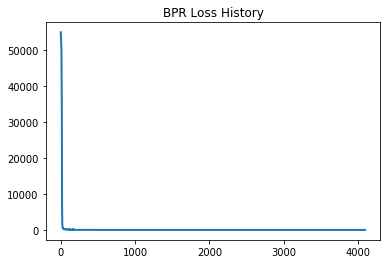

In [59]:
plt.plot([x for x in range(len(loss_history))], loss_history, linewidth=2.0)
plt.title('BPR Loss History')
plt.show()

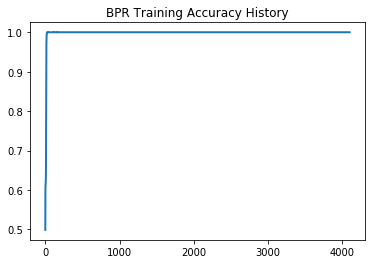

In [60]:
plt.plot([x for x in range(len(train_accuracy_history))], train_accuracy_history, linewidth=2.0)
plt.title('BPR Training Accuracy History')
plt.show()

In [61]:
np.save('./data/complete_itemGamma', itemGamma)
np.save('./data/complete_itemBiases', itemBiases)
np.save('./data/complete_userGamma', userGamma)
np.save('./data/complete_loss', loss_history)
np.save('./data/complete_train_accuracy', train_accuracy_history)

In [62]:
def predict_user(user):
    """
    returns the predicted ratings for the specified user,
    this is mainly used in computing evaluation metric
    """
    user_pred = []
    labels = []
    copy_items = copy.deepcopy(items)
    for i in itemsPerUser[user]:
        copy_items.remove(i)
        j = random.choice(copy_items)
        predict = sigmoid(prediction(user, i, j))
        copy_items.append(i)
        user_pred.append(predict)
        labels.append(binary_label(u, i, j))
        
    return np.array(labels), np.array(user_pred)

In [63]:
def auc_score():
    score = 0.0
    n_user = 0
    for user in tqdm(users):
        if len(itemsPerUser[user]) == 0: continue
        y_true, y_pred = predict_user(user)
        n_user += 1
        if len(np.unique(y_true)):
            score += accuracy_score(y_true, np.rint(y_pred))
        else:
            score += roc_auc_score(y_true, y_pred)
    score /= n_user
    return score

In [64]:
auc_score()

100%|██████████| 87626/87626 [13:26<00:00, 108.68it/s]


0.767580259801248

# Map a Sample for Played and Purchased Items

In [66]:
playedItemsPerUser = defaultdict(set)
for u in itemsPerUser:
    for i in itemsPerUser[u]:
        if playtimesPerUser[u][i] > 0:
            playedItemsPerUser[u].add(i)

In [67]:
played_user_item_counts = dict((k, len(v)) for k, v in playedItemsPerUser.items())

In [72]:
played_datafile = 'data/played_sample_in.tsv'
played_mapout1 = 'data/played_sample_map1.tsv'
played_mapout2 = 'data/played_sample_map2.tsv'
played_outfile = 'data/played_sample_out.tsv'

f = open(played_datafile,'w')
for u, its in playedItemsPerUser.items():
    for i in its:
        print(default_formatter(u,i), file=f)
f.close()

In [73]:
# run two stages of mapreduce
played_mapper = Mapper(played_user_item_counts)
mapreduce(played_datafile, played_mapout1, mapper=played_mapper, reducer=reducer)
mapreduce(played_datafile, played_mapout2, mapper=indicator_mapper)  # map the data again
mapreduce([played_mapout1, played_mapout2], played_outfile, reducer=indicator_reducer)

In [74]:
mixed_data = create_data(played_outfile)

In [75]:
played_data = []
for u, i, j in mixed_data:
    c = Counter(itemsPerUser[u])
    if c[j] > 0:
        played_data.append((u, i, j))

In [76]:
played_sample_data = train_test_split(played_data, train_size=0.05)[0]

In [78]:
playedSampleUsersPerItem = defaultdict(set)
playedSampleItemsPerUser = defaultdict(set)

In [79]:
for u, i, j in played_sample_data:
    playedSampleUsersPerItem[i].add(u)
    playedSampleItemsPerUser[u].add(i)

In [80]:
played_train_data = played_sample_data
playedSampleItems = list(playedSampleUsersPerItem.keys())
playedSampleUsers = list(playedSampleItemsPerUser.keys())

In [103]:
played_test_data = []
for u in playedSampleItemsPerUser:
    for i in playedSampleItemsPerUser[u]:
        j = random.choice(itemsPerUser[u])
        played_test_data.append((u, i, j))

In [104]:
def binary_played_label(u, i, j):
    if playtimesPerUser[u][i] >= playtimesPerUser[u][j]:
        return 1
    else:
        return 0

In [105]:
played_train_labels = [binary_played_label(u, i, j) for u, i, j in played_train_data]

## Run the new data set on the two latent factor models 

\begin{equation*}
P(played | purchased)
\end{equation*}

### Bias Only

In [91]:
loss_history = []
train_accuracy_history = []

In [92]:
played_res, played_f, played_d = sy.optimize.fmin_l_bfgs_b(cost, [0.0]*nItems, derivative, args=[0.001, played_train_data, played_train_labels])

iteration 1 Cost: 1765.4458688860825
iteration 1 Training Accuracy: 0.0
-------------------------------------------------------------------
iteration 2 Cost: 1697.5387180736266
iteration 2 Training Accuracy: 0.8036906164114644
-------------------------------------------------------------------
iteration 3 Cost: 1218.6805063828542
iteration 3 Training Accuracy: 0.8390263054574009
-------------------------------------------------------------------
iteration 4 Cost: 1018.3062974210262
iteration 4 Training Accuracy: 0.8543384373773066
-------------------------------------------------------------------
iteration 5 Cost: 838.2684913833236
iteration 5 Training Accuracy: 0.8841774636827641
-------------------------------------------------------------------
iteration 6 Cost: 690.8179578370224
iteration 6 Training Accuracy: 0.8951707891637221
-------------------------------------------------------------------
iteration 7 Cost: 630.1072563958088
iteration 7 Training Accuracy: 0.9073419709462113
-

iteration 55 Cost: 479.26301006265203
iteration 55 Training Accuracy: 0.9195131527287004
-------------------------------------------------------------------
iteration 56 Cost: 479.22825627448714
iteration 56 Training Accuracy: 0.9199057714958775
-------------------------------------------------------------------
iteration 57 Cost: 479.2027878638682
iteration 57 Training Accuracy: 0.9202983902630546
-------------------------------------------------------------------
iteration 58 Cost: 479.1613628093532
iteration 58 Training Accuracy: 0.9202983902630546
-------------------------------------------------------------------
iteration 59 Cost: 479.23463166573043
iteration 59 Training Accuracy: 0.9187279151943463
-------------------------------------------------------------------
iteration 60 Cost: 479.1457656475764
iteration 60 Training Accuracy: 0.9202983902630546
-------------------------------------------------------------------
iteration 61 Cost: 479.1225614658671
iteration 61 Training Ac

iteration 109 Cost: 478.8801962723627
iteration 109 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 110 Cost: 478.87827263624933
iteration 110 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 111 Cost: 478.8778757958653
iteration 111 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 112 Cost: 478.8768509096062
iteration 112 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 113 Cost: 478.877364937837
iteration 113 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 114 Cost: 478.876297552278
iteration 114 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 115 Cost: 478.87567714339497
iteration 115 

iteration 161 Cost: 478.8653445957304
iteration 161 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 162 Cost: 478.865323938414
iteration 162 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 163 Cost: 478.86529779126903
iteration 163 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 164 Cost: 478.86528110646583
iteration 164 Training Accuracy: 0.9195131527287004
-------------------------------------------------------------------
iteration 165 Cost: 478.8652483196016
iteration 165 Training Accuracy: 0.9195131527287004
-------------------------------------------------------------------
iteration 166 Cost: 478.8652362639984
iteration 166 Training Accuracy: 0.9195131527287004
-------------------------------------------------------------------
iteration 167 Cost: 478.86522303771915
iteration 16

iteration 213 Cost: 478.864892088128
iteration 213 Training Accuracy: 0.9195131527287004
-------------------------------------------------------------------
iteration 214 Cost: 478.8648904520804
iteration 214 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 215 Cost: 478.86488887690825
iteration 215 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 216 Cost: 478.8648876602863
iteration 216 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 217 Cost: 478.86488650902965
iteration 217 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------
iteration 218 Cost: 478.86488556980174
iteration 218 Training Accuracy: 0.9191205339615234
-------------------------------------------------------------------


In [93]:
played_d

{'grad': array([ 0.00000000e+00, -9.26374008e-05,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'funcalls': 218,
 'nit': 207,
 'warnflag': 0}

In [94]:
unpack(played_res)

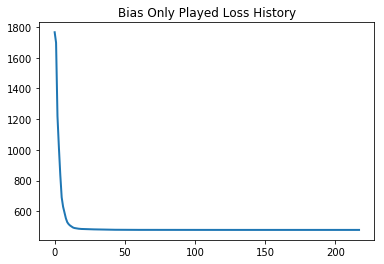

In [97]:
graph(loss_history, 'Bias Only Played Loss History')

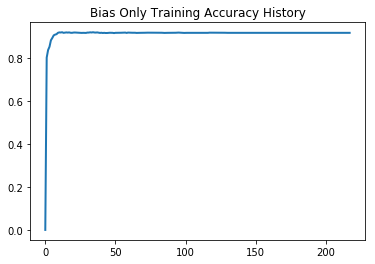

In [98]:
graph(train_accuracy_history, 'Bias Only Training Accuracy History')

In [106]:
predictions, labels = generate_outputs(played_test_data, binary_played_label)

In [107]:
accuracy(predictions, labels)

0.5441696113074205

### Complete

In [108]:
loss_history = []
train_accuracy_history = []

In [113]:
complete_played_res, complete_played_f, complete_played_d = sy.optimize.fmin_l_bfgs_b(cost, 
                                [0.0]*nItems + # Initialize beta
                                [random.random() * 0.1 - 0.05 for k in range(K*(nUsers + nItems))], # Gamma
                                derivative, args=[0.001, played_train_data, played_train_labels])

iteration 2 Cost: 1766.3383856626906
iteration 2 Training Accuracy: 0.48920298390263056
-------------------------------------------------------------------
iteration 3 Cost: 1698.2768924376655
iteration 3 Training Accuracy: 0.8248920298390263
-------------------------------------------------------------------
iteration 4 Cost: 1215.0730684404527
iteration 4 Training Accuracy: 0.8413820180604633
-------------------------------------------------------------------
iteration 5 Cost: 1008.8722095552782
iteration 5 Training Accuracy: 0.8578720062819003
-------------------------------------------------------------------
iteration 6 Cost: 763.4134438506517
iteration 6 Training Accuracy: 0.8936003140950137
-------------------------------------------------------------------
iteration 7 Cost: 348.79494926440293
iteration 7 Training Accuracy: 0.9595602669807617
-------------------------------------------------------------------
iteration 8 Cost: 48.302318973647296
iteration 8 Training Accuracy: 0.

iteration 59 Cost: 10.376623993427454
iteration 59 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 60 Cost: 10.355799351501481
iteration 60 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 61 Cost: 10.345976939995841
iteration 61 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 62 Cost: 10.335468866986542
iteration 62 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 63 Cost: 10.334617435604533
iteration 63 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 64 Cost: 10.314543619015474
iteration 64 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 65 Cost: 10.31938065001856
iteration 65 Training Accuracy: 1.0
-------------------------------------------------------------------
iterati

iteration 117 Cost: 10.135692340918322
iteration 117 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 118 Cost: 10.134887039373144
iteration 118 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 119 Cost: 10.133521826591597
iteration 119 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 120 Cost: 10.133250289706059
iteration 120 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 121 Cost: 10.13274784976614
iteration 121 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 122 Cost: 10.13166666000604
iteration 122 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 123 Cost: 10.130466234898034
iteration 123 Training Accuracy: 1.0
--------------------------------------------------------------

iteration 174 Cost: 10.108730023638797
iteration 174 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 175 Cost: 10.108601179449916
iteration 175 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 176 Cost: 10.108502402142173
iteration 176 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 177 Cost: 10.108385632809206
iteration 177 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 178 Cost: 10.108249908775436
iteration 178 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 179 Cost: 10.108130330338705
iteration 179 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 180 Cost: 10.108009896400356
iteration 180 Training Accuracy: 1.0
------------------------------------------------------------

iteration 231 Cost: 10.10516477545038
iteration 231 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 232 Cost: 10.105144348136449
iteration 232 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 233 Cost: 10.105127140373138
iteration 233 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 234 Cost: 10.10511177279012
iteration 234 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 235 Cost: 10.10509583583331
iteration 235 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 236 Cost: 10.105077215349588
iteration 236 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 237 Cost: 10.10506284703224
iteration 237 Training Accuracy: 1.0
----------------------------------------------------------------

iteration 288 Cost: 10.104681089858518
iteration 288 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 289 Cost: 10.104677854377751
iteration 289 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 290 Cost: 10.10467229295593
iteration 290 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 291 Cost: 10.104666041515063
iteration 291 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 292 Cost: 10.10465914927092
iteration 292 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 293 Cost: 10.104653487097858
iteration 293 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 294 Cost: 10.104647548239747
iteration 294 Training Accuracy: 1.0
--------------------------------------------------------------

iteration 345 Cost: 10.104315866384862
iteration 345 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 346 Cost: 10.104307686514007
iteration 346 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 347 Cost: 10.104296624265096
iteration 347 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 348 Cost: 10.104289573206968
iteration 348 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 349 Cost: 10.104278134333764
iteration 349 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 350 Cost: 10.10426636005873
iteration 350 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 351 Cost: 10.104258297518625
iteration 351 Training Accuracy: 1.0
-------------------------------------------------------------

iteration 402 Cost: 10.103730474766946
iteration 402 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 403 Cost: 10.103722648231006
iteration 403 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 404 Cost: 10.103709846738235
iteration 404 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 405 Cost: 10.103701533175785
iteration 405 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 406 Cost: 10.103692510182034
iteration 406 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 407 Cost: 10.103684777980105
iteration 407 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 408 Cost: 10.103676720097521
iteration 408 Training Accuracy: 1.0
------------------------------------------------------------

iteration 459 Cost: 10.10335816455999
iteration 459 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 460 Cost: 10.103355279336807
iteration 460 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 461 Cost: 10.103352661734736
iteration 461 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 462 Cost: 10.103349107202355
iteration 462 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 463 Cost: 10.103345631506981
iteration 463 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 464 Cost: 10.103343394096642
iteration 464 Training Accuracy: 1.0
-------------------------------------------------------------------
iteration 465 Cost: 10.103340789460661
iteration 465 Training Accuracy: 1.0
-------------------------------------------------------------

In [114]:
complete_played_d

{'grad': array([ 0.00000000e+00,  9.79270937e-07,  0.00000000e+00, ...,
         1.00210393e-09, -2.37455733e-09, -8.57667001e-10]),
 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
 'funcalls': 475,
 'nit': 454,
 'warnflag': 0}

In [115]:
unpack(complete_played_res)

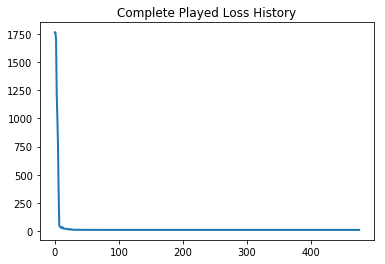

In [116]:
graph(loss_history, 'Complete Played Loss History')

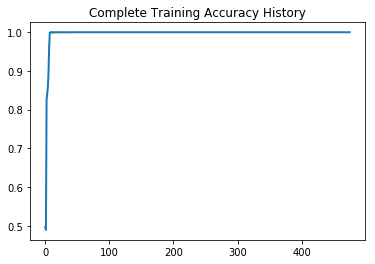

In [117]:
graph(train_accuracy_history, 'Complete Training Accuracy History')

In [118]:
predictions, labels = generate_outputs(played_test_data, binary_played_label)

In [119]:
accuracy(predictions, labels)

0.7090694935217904

# t-SNE Visualization for Low Dimensional Users and Items

In [ ]:
feat_cols = ["Played", "Purchased", "New"]
df = pd.DataFrame(sample_item_factors.T ,columns=feat_cols)

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(sample_item_factors)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
df = pd.DataFrame(tsne_results, columns=["tsne-2d-one", "tsne-2d-two"])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)